In [1]:
import ris 
from ris import __version__
from ris import pysqldb
import pandas as pd
import getpass
import datetime 
import numpy as np 

timestamp = datetime.datetime.now().strftime('%Y%m%d')
Markdown('<strong>Notebook run on: {} | by {} | Using ris library version: {}'.format(
    datetime.datetime.now().strftime('%Y-%m-%d %H:%M'), getpass.getuser(), __version__
))

<strong>Notebook run on: 2023-04-24 12:16 | by ccahill | Using ris library version: 2.5.3 - noarcpy

# Intro 

This code compares the B-summons on Open Data (a frozen version of which exists in the database). This shows trends in B-summons throughout the post-Covid era compared to pre-Covid. This also matches certain types of B-summons with certain types of crashes and compares mismatches. 

Notes:
- Most of this could be updated to include CY 2022
- The groupings are rough and not set in stone 
- **NOT DONE HERE BUT POTENTIALLY IMPORTANT**: NYPD also does targeted enforcement on corridors--these could then be matched to crash data to show their efficacy. However, do note, many B-summons are matched to the precinct HQ, not to a meaningful location. 

Setup

In [2]:
db = pysqldb.DbConnect(type='PG', server='dotdevrhpgsql01', default=True, allow_temp_tables=True)
db.kill_blocks()
writer = pd.ExcelWriter('Violations_20230424.xlsx')


Additional database connection details required:


User name (ris): ccahill
Password (ris) ········


- Query failed: cannot drop table working.speed_camera_vio_16_18 because other objects depend on it
DETAIL:  view working.speed_camera_vio depends on table working.speed_camera_vio_16_18
HINT:  Use DROP ... CASCADE to drop the dependent objects too.

	
- Query run 2023-04-24 12:16:44.021000
	DROP TABLE IF EXISTS working.speed_camera_vio_16_18 
- Query failed: cannot drop table working.speed_camera_vio_19 because other objects depend on it
DETAIL:  view working.speed_camera_vio depends on table working.speed_camera_vio_19
HINT:  Use DROP ... CASCADE to drop the dependent objects too.

	
- Query run 2023-04-24 12:16:44.026000
	DROP TABLE IF EXISTS working.speed_camera_vio_19 
- Query failed: cannot drop table working.speed_camera_vio_20 because other objects depend on it
DETAIL:  view working.speed_camera_vio depends on table working.speed_camera_vio_20
HINT:  Use DROP ... CASCADE to drop the dependent objects too.

	
- Query run 2023-04-24 12:16:44.028000
	DROP TABLE IF EXISTS working.s

Historical Violations

From https://data.cityofnewyork.us/Public-Safety/NYPD-B-Summons-Historic-/bme5-7ty4

In [3]:
db.csv_to_table('C:\Users\ccahill\Downloads\NYPD_B_Summons__Historic_.csv', schema='working', table='historic_summons', overwrite=True)

Bulk loading data...


            3080653 rows added to working.historic_summons. 
            The table name may include stg_. This will not change the end result. 
            


"YTD" Violations 

Really includes 2021 mainly

From https://data.cityofnewyork.us/Public-Safety/NYPD-B-Summons-Year-to-Date-/57p3-pdcj

In [4]:
db.csv_to_table('C:\Users\ccahill\Downloads\NYPD_B_Summons__Year_to_Date_.csv', schema='working', table='summons_ytd')

Must set overwrite=True; table already exists.


Violation Codes from NYSDMV 

From: https://dmv.ny.gov/e-data/violationcodes.xlsx

In [5]:
db.xls_to_table(r'C:\Users\ccahill\Downloads\violationcodes(1).xlsx', schema='working', table='violation_codes', overwrite=True)

Bulk loading data...


            584 rows added to working.stg_violation_codes. 
            The table name may include stg_. This will not change the end result. 
            
- Query run 2023-04-24 12:18:28.033000
 Query time: Query run in 22000 microseconds 
 * Returned 0 rows *


Redo Violation Code table to have 1 code/law type per row

In [6]:
db.dfquery("""
drop table if exists working.violation_codes_stg; 
create table working.violation_codes_stg as 

select 
    law_title, 
    adj_code, 
    array_agg(distinct law_code_printed_on_ticket)::varchar as law_codes, 
    array_agg(distinct description)::varchar as description 
from
    working.violation_codes
group by 1, 2; 

drop table if exists working.violation_codes; 
create table working.violation_codes as select * from working.violation_codes_stg; 

drop table if exists working.violation_codes_stg;

""")

- Query failed: relation "working.violation_codes_stg" does not exist

	
- Query run 2023-04-24 12:18:28.245000
	grant select on working.violation_codes_stg to public;
- Query failed: relation "working.violation_codes_stg" does not exist

	
- Query run 2023-04-24 12:18:28.247000
	COMMENT ON TABLE working.violation_codes_stg IS 'Created by ccahill on 2023-04-24 12:18
'


""


Create Base Summons Table 

- Contains geom 
- Contains actual description of summons 
- Unions historic and YTD summons 

In [7]:
db.dfquery("""

drop table if exists working.loaded_summons; 
create table working.loaded_summons as 

select distinct 
    evnt_key, violation_date, violation_time, chg_law_cd, violation_code, veh_category, city_nm, rpt_owning_cmd, x_coord_cd, y_coord_cd, latitude, longitude, 
    st_transform(st_setsrid(location::geometry, 4326), 2263) as geom, 
    vc.description 
from 
    working.historic_summons s 
left join 
    working.violation_codes vc 
on 
    s.violation_code = vc.adj_code
    and 
    (s.chg_law_cd = vc.law_title or (s.chg_law_cd = 'TBT' and vc.law_title='TBTA') or (s.chg_law_cd = 'NYC' and vc.law_title='NYCTRR'))
      
union 

select distinct 
    evnt_key, violation_date, violation_time, chg_law_cd, violation_code, veh_category, city_nm, rpt_owning_cmd, x_coord_cd, y_coord_cd, latitude, longitude, 
    st_transform(st_setsrid(location_point::geometry, 4326), 2263) as geom, 
    vc.description 
from 
    working.summons_ytd s 
left join 
    working.violation_codes vc 
on 
    s.violation_code = vc.adj_code
    and 
    (s.chg_law_cd = vc.law_title or (s.chg_law_cd = 'TBT' and vc.law_title='TBTA') or (s.chg_law_cd = 'NYC' and vc.law_title='NYCTRR'))

;

""") 

""


Add Precinct 

In [8]:
db.dfquery("""
alter table working.loaded_summons add police_precinct int;

update 
    working.loaded_summons s
set 
    police_precinct=p.precinct 
from 
    districts_police_precincts p 
where 
    st_intersects(p.geom, s.geom)

""")

""


 Add Category Labels

In [9]:
db.dfquery("""

alter table working.loaded_summons add category varchar(256); 
update working.loaded_summons 
set 
    category = 
    case
        when (lower(description) like '%fail%stop%' or lower(description) like '%disobey%' or lower(description) like '%redlight%') then 'Disobeying Traffic Signal or Sign/Fail to Stop/Redlight'
        when (lower(description) like '%speed%' and lower(description) not like '%speedometer%') then 'Speed Related'
        when (lower(description) like '%phone%' or lower(description) like '%electronic%') then 'Phone/Electronics Related'
        when (lower(description) like '%fail%yield%') then 'Fail to Yield'
        when (lower(description) like '%seat%belt%' or lower(description) like '%restraint%') then 'Seatbelt/Restraint Related'
        when (lower(description) like '%improper%turn%') then 'Improper Turn'
        when (lower(description) like '%fail%due%') then 'Fail to Exercise Due Care'
        when (lower(description) like '%insur%') then 'Insurance Related'
        when (lower(description) like '%unregistered%') then 'Registration Related'
        when (lower(description) like '%licens%') then 'License Related'
        when (lower(description) like '%nontrans%') then 'Aesthetic'
        when (lower(description) like '%bus%lane%') then 'Bus Lane Related'
        when (lower(description) like '%fail%signal%' or lower(description)  like '%improper signal%') then 'Fail/Improper Signaling'
        else 'Other'
    end 

""")

""


## Reporting

Yearly Violations

In [10]:
db.dfquery("""

select distinct 
    date_part('year', violation_date::date)::int "Year", 
    count(*) as "Violations (excl. bikes, micromobility, etc.)"
from 
    working.loaded_summons s 
where 
    veh_category in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
group by 1 

""").to_excel(writer, 'YearlyMVViolations', index=False)

In [11]:
db.dfquery("""

select distinct 
    case 
        when violation_date::date < '2020-01-01' then 'Before Covid (2018-2019 Avg.)' 
        else 'After Covid (2020-2021 Avg.)'
    end as "Period",
    round(count(*)/2.0) as "Annual MV Violations (excl. Bikes, Micromobility, etc.)"
from 
    working.loaded_summons s 
where 
    veh_category in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
group by 1 
order by 1 desc

""").to_excel(writer, 'BeforeAfterMVViolations', index=False)

In [12]:
db.dfquery("""

select distinct 
    date_part('year', violation_date::date)::int "Year", 
    count(*) "Violations (Bikes, Micromobility, ATVs, etc.)"
from 
    working.loaded_summons s 
where 
    veh_category not in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
group by 1 

""").to_excel(writer, 'YearlyNonMVViolations', index=False)

In [13]:
db.dfquery("""

select distinct 
    case 
        when violation_date::date < '2020-01-01' then 'Before Covid (2018-2019 Avg.)' 
        else 'After Covid (2020-2021 Avg.)'
    end as "Period",
    round(count(*)/2.0) as "Annual Violations (Bikes, Micromobility, ATVs, etc.)"
from 
    working.loaded_summons s 
where 
    veh_category not in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
group by 1 
order by 1 desc

""").to_excel(writer, 'BeforeAfterNonMVViolations', index=False)

Monthly Violations

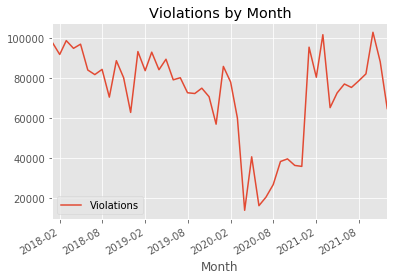

In [14]:
db.dfquery("""

select distinct 
    date_trunc('month', violation_date::date) "Month", 
    count(*) "Violations"
from 
    working.loaded_summons s 
where 
    veh_category in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
group by 1 

""").plot(x='Month', y='Violations', title='Violations by Month').get_figure().savefig('MonthlyViolationsOverTime.png') 

In [15]:
yr_mo_df = db.dfquery("""

select distinct 
    date_part('year', violation_date::date)::int "Year", 
    date_part('month', violation_date::date)::int "Month", 
    count(*)
from 
    working.loaded_summons s 
where 
    veh_category in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
group by 1, 2 

""").pivot(index='Month', columns='Year', values='count').reset_index()

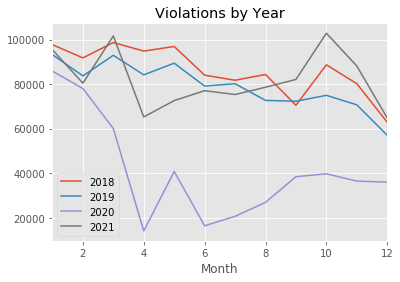

In [16]:
ax = yr_mo_df.plot(x='Month', y=2018)
ax = yr_mo_df.plot(x='Month', y=2019, ax=ax)
ax = yr_mo_df.plot(x='Month', y=2020, ax=ax)
ax = yr_mo_df.plot(x='Month', y=2021, ax=ax, title='Violations by Year').get_figure().savefig('MonthlyViolationsByYear.png') 

Boro

In [17]:
db.dfquery("""

select distinct 
    initcap(CASE 
        WHEN police_precinct BETWEEN 1 AND 34 THEN 'MANHATTAN'
        WHEN police_precinct BETWEEN 40 AND 52 THEN 'BRONX'
        WHEN police_precinct BETWEEN 60 AND 94 THEN 'BROOKLYN'
        WHEN police_precinct BETWEEN 100 AND 115 THEN 'QUEENS'
        WHEN police_precinct BETWEEN 120 AND 123 THEN 'STATEN ISLAND'
        else NULL 
    end) as boro,  
    date_part('year', violation_date::date)::int "Year", 
    count(*)
from
    working.loaded_summons s 
where 
    veh_category in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
group by 1, 2

""").pivot(index='Year', columns='boro').reset_index().reset_index(drop=True).to_excel(writer, sheet_name='BoroughYearlyMV')


In [18]:
boro_period_df = db.dfquery("""

select distinct 
    initcap(CASE 
        WHEN police_precinct BETWEEN 1 AND 34 THEN 'MANHATTAN'
        WHEN police_precinct BETWEEN 40 AND 52 THEN 'BRONX'
        WHEN police_precinct BETWEEN 60 AND 94 THEN 'BROOKLYN'
        WHEN police_precinct BETWEEN 100 AND 115 THEN 'QUEENS'
        WHEN police_precinct BETWEEN 120 AND 123 THEN 'STATEN ISLAND'
        else 'Other/Unknown' 
    end) as boro,  
    case 
        when violation_date::date < '2020-01-01' then 'Before Covid (2018-2019 Avg.)' 
        else 'After Covid (2020-2021 Avg.)'
    end as "Period",
    round(count(distinct evnt_key)/2.0)::float as "Violations"
from
    working.loaded_summons s 
where 
    veh_category in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
group by 1, 2

union 


select distinct 
    'Citywide' as boro,  
    case 
        when violation_date::date < '2020-01-01' then 'Before Covid (2018-2019 Avg.)' 
        else 'After Covid (2020-2021 Avg.)'
    end as "Period",
    round(count(distinct evnt_key)/2.0)::float as "Violations"
from
    working.loaded_summons s 
where 
    veh_category in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
group by 1, 2


""").pivot(index='Period', columns='boro', values='Violations').reset_index().reset_index(drop=True).sort_values(by='Period', ascending=False)

boro_period_df = boro_period_df.set_index('Period').T
boro_period_df['% Change'] = (boro_period_df['After Covid (2020-2021 Avg.)']/boro_period_df['Before Covid (2018-2019 Avg.)'] - 1)*100.0
boro_period_df.T.reset_index().round(2).to_excel(writer, sheet_name='BoroughBeforeAfterMV', index=False)


In [19]:
pct_breakdown = db.dfquery("""

with pre_covid_avg as (

    select 
        initcap(CASE 
            WHEN police_precinct BETWEEN 1 AND 34 THEN 'MANHATTAN'
            WHEN police_precinct BETWEEN 40 AND 52 THEN 'BRONX'
            WHEN police_precinct BETWEEN 60 AND 94 THEN 'BROOKLYN'
            WHEN police_precinct BETWEEN 100 AND 115 THEN 'QUEENS'
            WHEN police_precinct BETWEEN 120 AND 123 THEN 'STATEN ISLAND'
            else NULL 
        end) as boro,     
        count(*)/24.0 as pre_covid_monthly_avg
    from 
        working.loaded_summons
    where 
        violation_date::date between '2018-01-01' and '2019-12-31'
    group by 1 

)

select distinct 
    initcap(CASE 
        WHEN police_precinct BETWEEN 1 AND 34 THEN 'MANHATTAN'
        WHEN police_precinct BETWEEN 40 AND 52 THEN 'BRONX'
        WHEN police_precinct BETWEEN 60 AND 94 THEN 'BROOKLYN'
        WHEN police_precinct BETWEEN 100 AND 115 THEN 'QUEENS'
        WHEN police_precinct BETWEEN 120 AND 123 THEN 'STATEN ISLAND'
        else NULL 
    end) as boro,  
    date_trunc('month', violation_date::date) "Month", 
    pre_covid_monthly_avg,
    count(*), 
    count(*)/(1.0*pre_covid_monthly_avg) as normalized
from 
    working.loaded_summons s 
join 
    pre_covid_avg p 
on 
    initcap(CASE 
        WHEN police_precinct BETWEEN 1 AND 34 THEN 'MANHATTAN'
        WHEN police_precinct BETWEEN 40 AND 52 THEN 'BRONX'
        WHEN police_precinct BETWEEN 60 AND 94 THEN 'BROOKLYN'
        WHEN police_precinct BETWEEN 100 AND 115 THEN 'QUEENS'
        WHEN police_precinct BETWEEN 120 AND 123 THEN 'STATEN ISLAND'
        else NULL 
    end)=p.boro 
where 
    veh_category in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
group by 1, 2, 3

""")

In [20]:
pct_breakdown['normalized'] = pct_breakdown['normalized'].astype('float')

Borough Breakdown

Bronx
Brooklyn
Staten Island
Manhattan
Queens


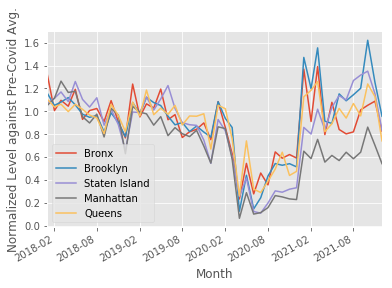

In [21]:
ax = None 

for i in set(pct_breakdown['boro']):
    print(i)
    if not ax: 
        ax = pct_breakdown[pct_breakdown['boro'] == i].plot(x='Month', y='normalized', label=i)
    else:
        ax = pct_breakdown[pct_breakdown['boro'] == i].plot(x='Month', y='normalized', ax=ax, label=i) 

ax.set_ylabel('Normalized Level against Pre-Covid Avg.')
ax.get_figure().savefig('BoroughByYear.png')

In [22]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', -1)

Category

Raw

In [23]:
raw_diff = db.dfquery("""

select distinct 
    category,  
    date_part('year', violation_date::date)::int "Year", 
    count(*)
from
    working.loaded_summons s 
where 
    veh_category in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
group by 1, 2

""")

raw_diff.pivot(index='Year', columns='category').reset_index().reset_index(drop=True).to_excel(writer, 'ViolationCategoryMVYearly')

In [24]:
raw_diff = raw_diff.pivot(index='Year', columns='category').reset_index().reset_index(drop=True)
raw_diff = raw_diff.set_index('Year').T
raw_diff['Before Covid (2018-2019 Avg.)'] = (raw_diff[2018] + raw_diff[2019])/2.0
raw_diff['After Covid (2020-2021 Avg.)'] = (raw_diff[2020] + raw_diff[2021])/2.0
raw_diff['% Change'] = (raw_diff['After Covid (2020-2021 Avg.)']/raw_diff['Before Covid (2018-2019 Avg.)'] - 1)*100.0
raw_diff.round(2)[['Before Covid (2018-2019 Avg.)', 'After Covid (2020-2021 Avg.)', '% Change']].T.reset_index().reset_index(drop=True).rename(columns={'Year': 'Period'})
raw_diff.to_excel(writer, 'ViolationsMVBeforeAfterCategory')

In [25]:
cat_breakdown = db.dfquery("""

with pre_covid_avg as (

    select 
        category, 
        count(*)/24.0 as pre_covid_monthly_avg
    from 
        working.loaded_summons
    where 
        violation_date::date between '2018-01-01' and '2019-12-31'
    group by 1 

)

select distinct 
    s.category,   
    date_trunc('month', violation_date::date) "Month", 
    pre_covid_monthly_avg,
    count(*), 
    count(*)/(1.0*pre_covid_monthly_avg) as normalized
from 
    working.loaded_summons s 
join 
    pre_covid_avg p 
on 
   s.category=p.category
where 
    veh_category in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
group by 1, 2, 3

""")

# ax = None 

# for i in set(cat_breakdown['category']):
#     if not ax: 
#         ax = cat_breakdown[cat_breakdown['category'] == i].plot(x='Month', y='count', label=i)
#     else:
#         ax = cat_breakdown[cat_breakdown['category'] == i].plot(x='Month', y='count', ax=ax, label=i)


Normalized

In [26]:
cat_breakdown['normalized'] = cat_breakdown['normalized'].astype('float')

In [27]:
# h1 = list(set(cat_breakdown['category']))[0:7]
# h2 = list(set(cat_breakdown['category']))[7:14]

In [28]:
# ax = None 

# for i in h1:
#     if not ax: 
#         ax = cat_breakdown[cat_breakdown['category'] == i].plot(x='Month', y='normalized', label=i)
#     else:
#         ax = cat_breakdown[cat_breakdown['category'] == i].plot(x='Month', y='normalized', ax=ax, label=i)

# plt.legend(loc=(1.04,0))
# plt.show()

In [29]:
# ax = None 

# for i in h2:
#     if not ax: 
#         ax = cat_breakdown[cat_breakdown['category'] == i].plot(x='Month', y='normalized', label=i)
#     else:
#         ax = cat_breakdown[cat_breakdown['category'] == i].plot(x='Month', y='normalized', ax=ax, label=i)

# plt.legend(loc=(1.04,0))
# plt.show()

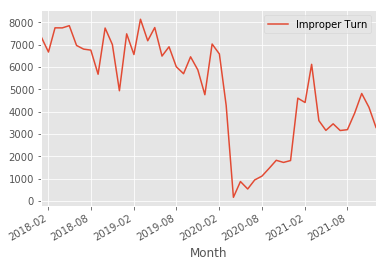

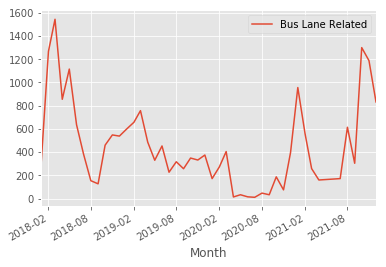

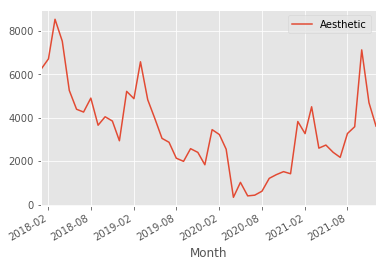

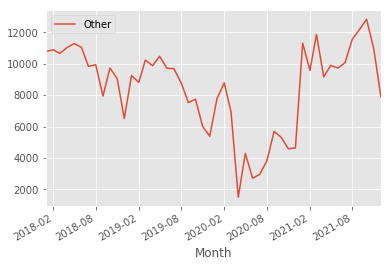

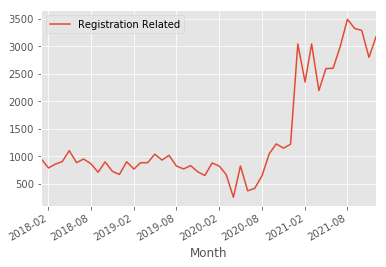

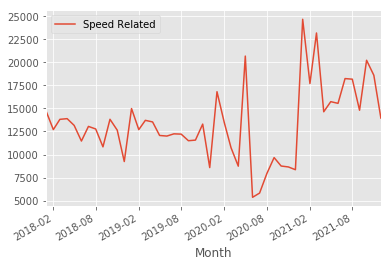

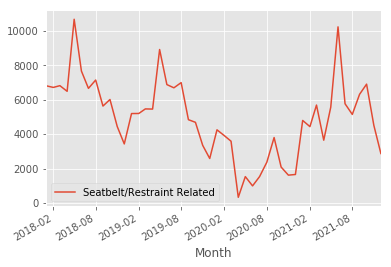

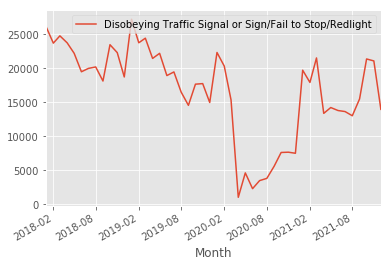

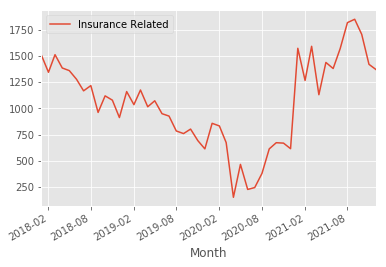

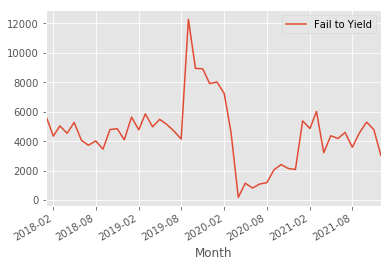

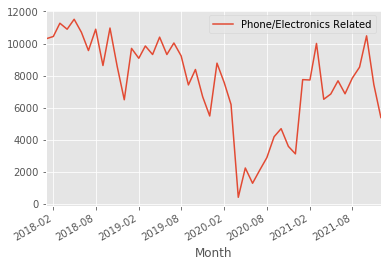

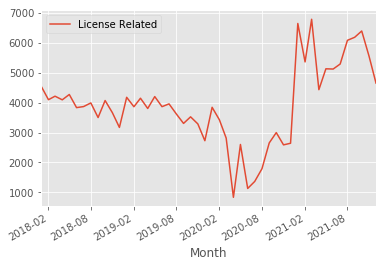

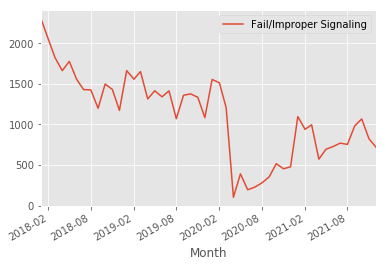

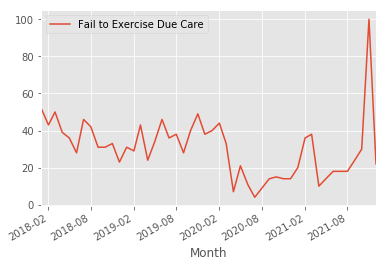

In [30]:
for i in set(cat_breakdown['category']):
    cat_breakdown[cat_breakdown['category'] == i].plot(x='Month', y='count', label=i).get_figure().savefig('{}RawViolationsMV'.format(i.replace(' ', '').replace('/', '')) + '.png')

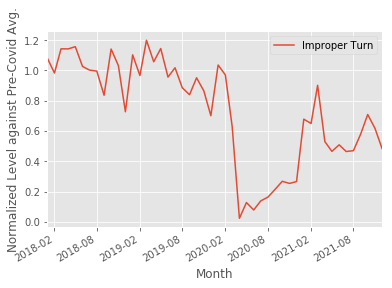

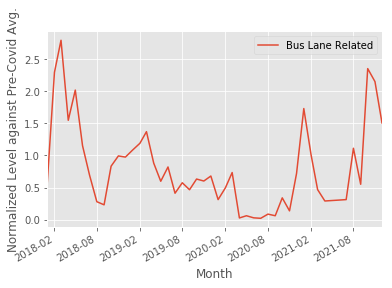

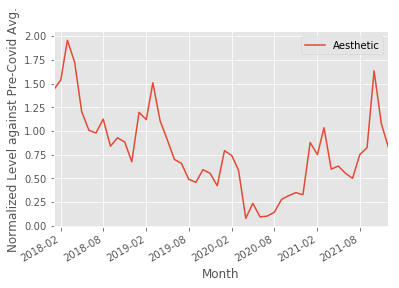

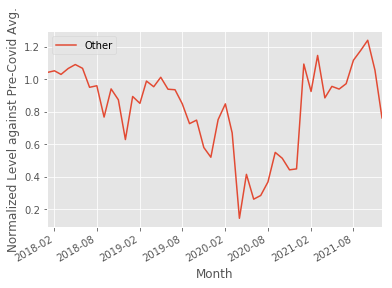

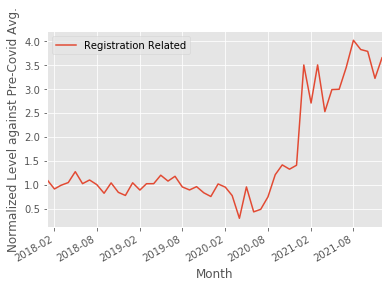

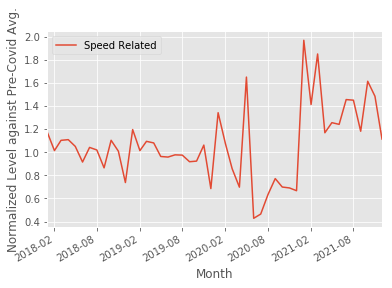

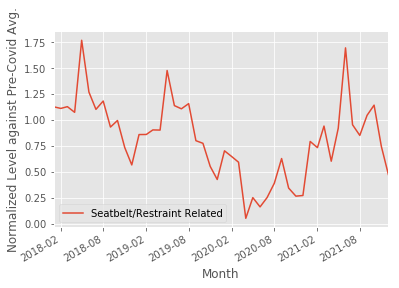

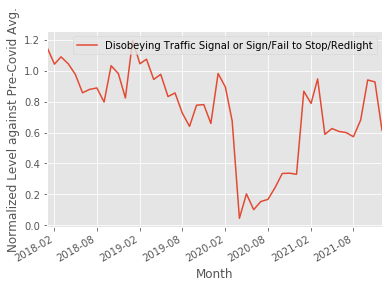

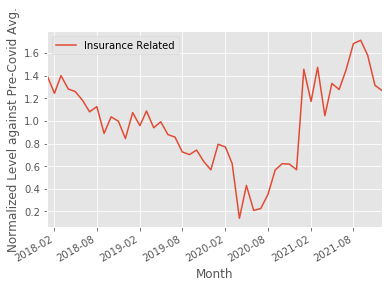

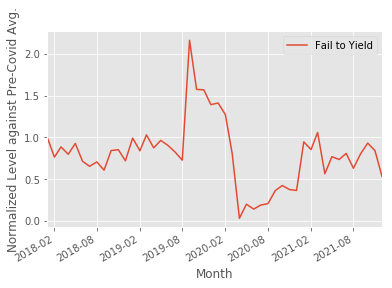

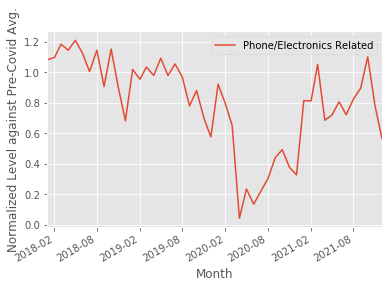

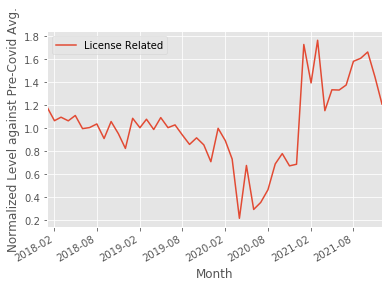

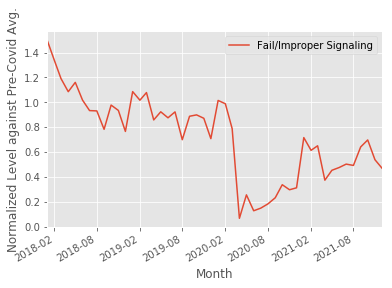

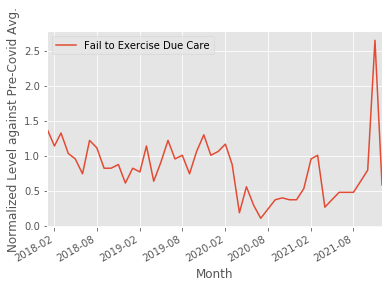

In [31]:
for i in set(cat_breakdown['category']):
    try:
        ax = cat_breakdown[cat_breakdown['category'] == i].plot(x='Month', y='normalized', label=i)
        ax.set_ylabel('Normalized Level against Pre-Covid Avg.')
        ax.get_figure().savefig('{}NormalizedViolationsMV'.format(i.replace(' ', '').replace('/', '')) + '.png')
    except:
        print(i)

Boro Category

Raw

In [32]:
boro_category = db.dfquery("""
with pre_covid_avg as (

    select 
        initcap(CASE 
            WHEN police_precinct BETWEEN 1 AND 34 THEN 'MANHATTAN'
            WHEN police_precinct BETWEEN 40 AND 52 THEN 'BRONX'
            WHEN police_precinct BETWEEN 60 AND 94 THEN 'BROOKLYN'
            WHEN police_precinct BETWEEN 100 AND 115 THEN 'QUEENS'
            WHEN police_precinct BETWEEN 120 AND 123 THEN 'STATEN ISLAND'
            else NULL 
        end) as boro, 
        category, 
        count(*)/2.0 as pre_covid_avg
    from 
        working.loaded_summons 
    where 
        veh_category in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
        and violation_date::date < '2020-01-01'
    group by 1, 2

)

select 
    date_part('year', violation_date::date)::int as year, 
    initcap(CASE 
        WHEN police_precinct BETWEEN 1 AND 34 THEN 'MANHATTAN'
        WHEN police_precinct BETWEEN 40 AND 52 THEN 'BRONX'
        WHEN police_precinct BETWEEN 60 AND 94 THEN 'BROOKLYN'
        WHEN police_precinct BETWEEN 100 AND 115 THEN 'QUEENS'
        WHEN police_precinct BETWEEN 120 AND 123 THEN 'STATEN ISLAND'
        else NULL 
    end) as boro, 
    s.category, 
    count(*), 
    count(*)/pre_covid_avg::float as normalized

from 
    working.loaded_summons s 
join 
    pre_covid_avg p 
on 
    initcap(CASE 
        WHEN police_precinct BETWEEN 1 AND 34 THEN 'MANHATTAN'
        WHEN police_precinct BETWEEN 40 AND 52 THEN 'BRONX'
        WHEN police_precinct BETWEEN 60 AND 94 THEN 'BROOKLYN'
        WHEN police_precinct BETWEEN 100 AND 115 THEN 'QUEENS'
        WHEN police_precinct BETWEEN 120 AND 123 THEN 'STATEN ISLAND'
        else NULL 
    end)=p.boro
    and s.category=p.category 
    
where 
    veh_category in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
group by 1, 2, 3, pre_covid_avg 

""")

In [33]:
boro_category['normalized'] = boro_category['normalized'].astype('float')

Improper Turn
Bus Lane Related
Aesthetic
Other
Registration Related
Speed Related
Seatbelt/Restraint Related
Disobeying Traffic Signal or Sign/Fail to Stop/Redlight
Insurance Related
Fail to Yield
Phone/Electronics Related
License Related
Fail/Improper Signaling
Fail to Exercise Due Care


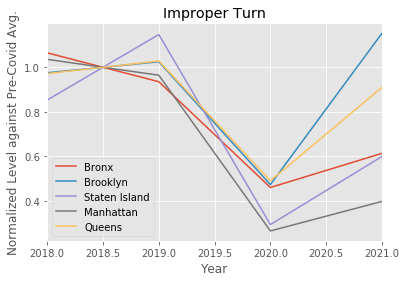

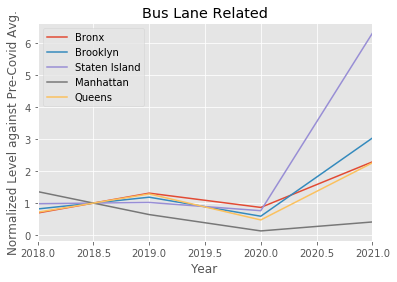

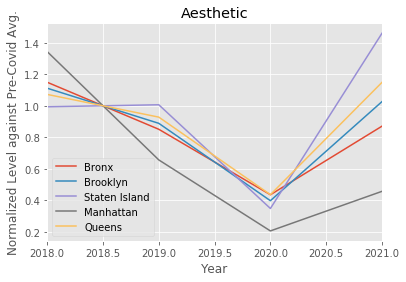

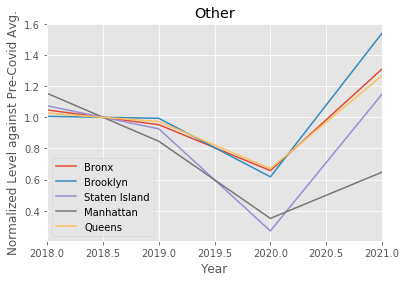

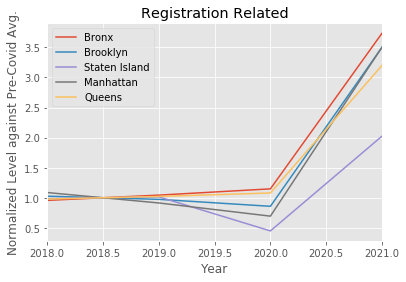

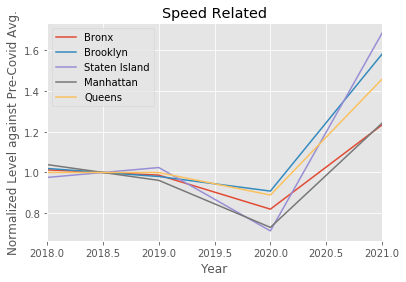

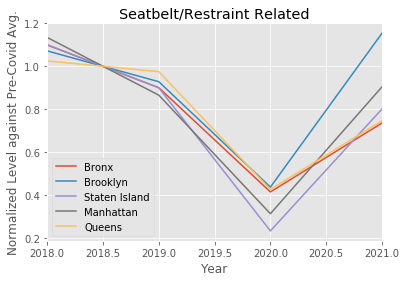

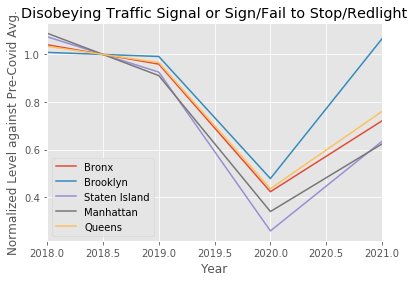

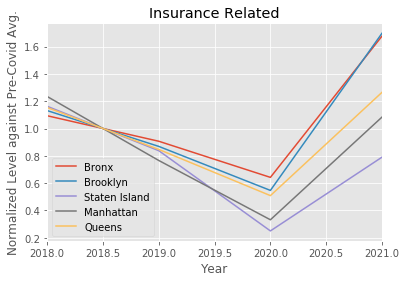

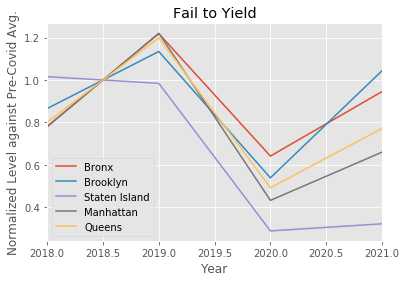

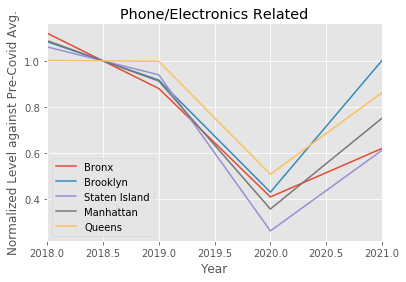

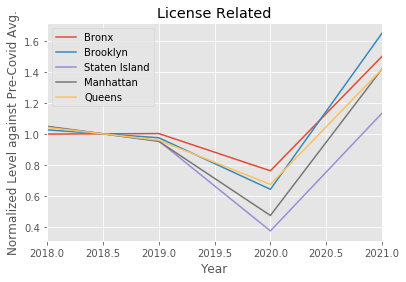

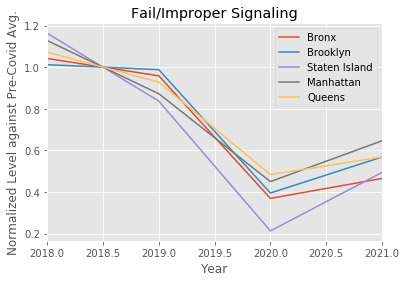

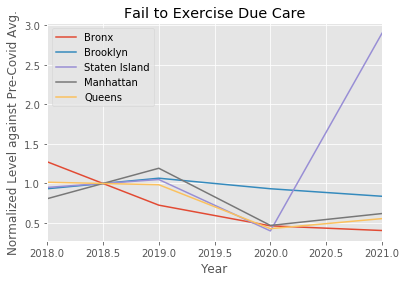

In [34]:
# From Stack!
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

for category in set(boro_category['category']):
    print(category)
    ax=None
    for boro in set(boro_category['boro']):
        if ax:
            ax = boro_category[boro_category['category'] == category].pivot(index='year', columns='boro', values='normalized').reset_index().plot(x='year', y=boro, label=boro, ax=ax, title=category)
            ax.set_xlabel('Year')
            ax.set_ylabel('Normalized Level against Pre-Covid Avg.')
        else:
            ax = boro_category[boro_category['category'] == category].pivot(index='year', columns='boro', values='normalized').reset_index().plot(x='year', y=boro, label=boro)
    plt.legend(loc=(1.04,0))
    legend_without_duplicate_labels(ax)
    ax.get_figure().savefig(category.replace(' ', '').replace('/', '') + 'BoroCategoryNormalized.png')


Raw Output

In [35]:
for boro in set(boro_category['boro']):
    d = boro_category[boro_category['boro'] == boro].pivot(index='year', columns='category', values='count').reset_index()
    d.to_excel(writer, '{}Category'.format(boro), index=False)
    
    cat_avg = d.set_index('year').T
    cat_avg['Before Covid (2018-2019 Avg.)'] = (cat_avg[2018] + cat_avg[2019])/2.0
    cat_avg['After Covid (2020-2021 Avg.)'] = (cat_avg[2020] + cat_avg[2021])/2.0
    cat_avg['% Change'] = (cat_avg['After Covid (2020-2021 Avg.)']/cat_avg['Before Covid (2018-2019 Avg.)'] - 1)*100.0
    cat_avg.round(2)[['Before Covid (2018-2019 Avg.)', 'After Covid (2020-2021 Avg.)', '% Change']].T.reset_index().reset_index(drop=True).rename(columns={'year': 'Period'}).to_excel(writer, '{}BeforeAfterCategory'.format(boro))

C:\Python27\ArcGIS10.7\lib\site-packages\openpyxl\workbook\child.py:102: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



## Link to Crash Types

Compare CF Before/After to Violation Categories 

In [36]:
yearly_cf_df = db.dfquery("""

select 
    cf, 
    date_part('year', crash_date)::int as "year", 
    count(distinct c.crashid)
from (
    select 
        contributing_factor_1 as cf, crashid 
    from
        wc_accident_vehicle_f ve 

    union 

    select 
        contributing_factor_2 as cf, crashid 
    from
        wc_accident_vehicle_f ve 
) u 
join 
    wc_accident_f c
on 
    u.crashid=c.crashid 
where 
    crash_date between '2018-01-01' and '2021-12-31'
group by 1, 2 
having count(*) > 1000

""").pivot(index='cf', columns='year', values='count')

cf_avg = yearly_cf_df #.set_index('year').T
cf_avg['Before Covid (2018-2019 Avg.)'] = (cf_avg[2018] + cf_avg[2019])/2.0
cf_avg['After Covid (2020-2021 Avg.)'] = (cf_avg[2020] + cf_avg[2021])/2.0
cf_avg['% Change'] = (cf_avg['After Covid (2020-2021 Avg.)']/cf_avg['Before Covid (2018-2019 Avg.)'] - 1)*100.0
cf_avg = cf_avg.round(2)[['Before Covid (2018-2019 Avg.)', 'After Covid (2020-2021 Avg.)', '% Change']].T.reset_index().reset_index(drop=True).rename(columns={'year': 'Period'})
cf_avg

C:\Python27\ArcGIS10.7\lib\site-packages\pandas\core\series.py:1999: RuntimeWarning:

invalid value encountered in rint



cf,Period,nan,aggressive driving/road rage,alcohol involvement,backing unsafely,brakes defective,driver inattention/distraction,driver inexperience,failure to yield right-of-way,following too closely,...,passing too closely,pavement slippery,pedestrian/bicyclist/other pedestrian error/confusion,reaction to uninvolved vehicle,traffic control disregarded,turning improperly,unsafe lane changing,unsafe speed,unspecified,view obstructed/limited
0,Before Covid (2018-2019 Avg.),21667.00,1877.00,2801.00,12558.00,1206.5,73704.50,7771.00,22573.00,31614.00,...,13854.00,3522.50,1808.00,5014.50,5957.00,8375.00,12667.00,6590.50,206228.00,3268.00
1,After Covid (2020-2021 Avg.),17707.00,1746.00,1971.00,4618.50,NaN,36359.00,5334.50,10886.50,12104.00,...,6417.00,1665.00,1352.00,2227.00,4760.50,3865.00,4654.50,6987.00,102327.50,1671.50
2,% Change,-18.28,-6.98,-29.63,-63.22,NaN,-50.67,-31.35,-51.77,-61.71,...,-53.68,-52.73,-25.22,-55.59,-20.09,-53.85,-63.25,6.02,-50.38,-48.85


Get monthly CF normalized values by CF

In [37]:
monthly_cf_df = db.dfquery("""

select 
    cf, 
    date_trunc('month', crash_date)::date as "month", 
    count(distinct c.crashid)
from (
    select 
        contributing_factor_1 as cf, crashid 
    from
        wc_accident_vehicle_f ve 

    union 

    select 
        contributing_factor_2 as cf, crashid 
    from
        wc_accident_vehicle_f ve 
) u 
join 
    wc_accident_f c
on 
    u.crashid=c.crashid 
join 
    (select distinct crashid from wc_accident_victim_f) vi 
on 
    c.crashid=vi.crashid
where 
    crash_date between '2018-01-01' and '2021-12-31'
group by 1, 2 
having count(*) > 50 

""") 

For each CF, calculate normalized values

In [38]:
for cf in set(monthly_cf_df['cf']):
    monthly_cf_df.loc[monthly_cf_df['cf'] == cf, 'normalized'] = monthly_cf_df['count']/(monthly_cf_df[(monthly_cf_df['cf'] == cf) & (pd.to_datetime(monthly_cf_df['month']).dt.year.isin([2018, 2019]))].sum()['count']/24.0)

None


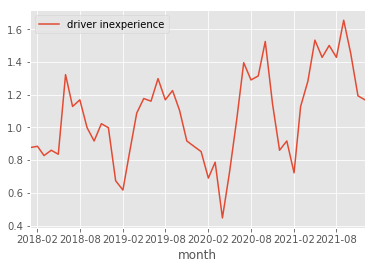

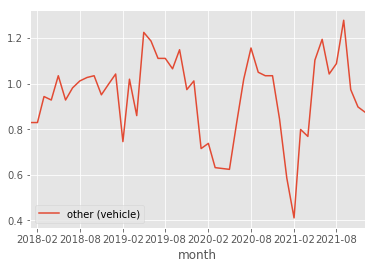

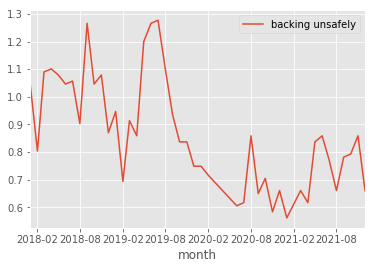

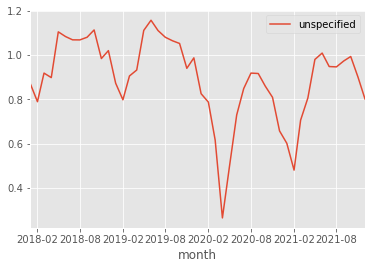

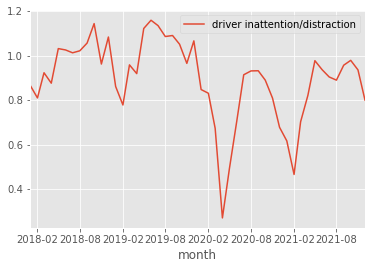

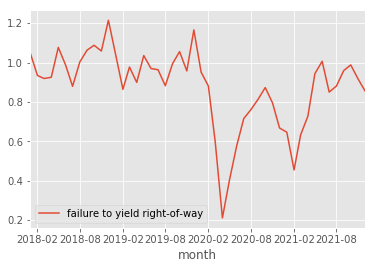

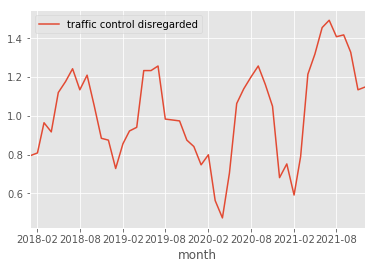

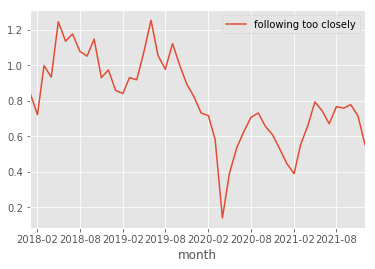

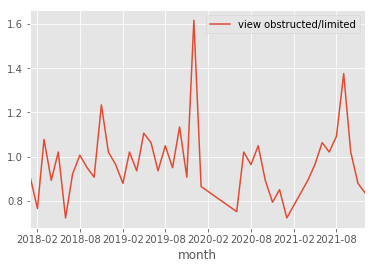

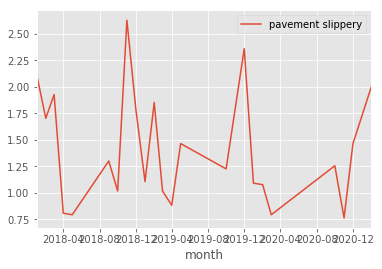

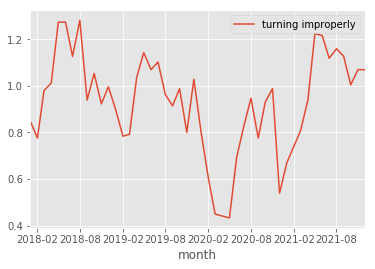

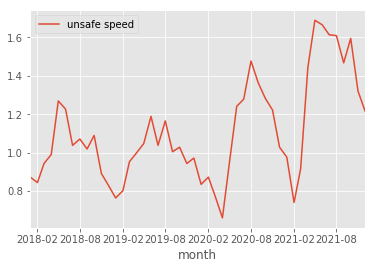

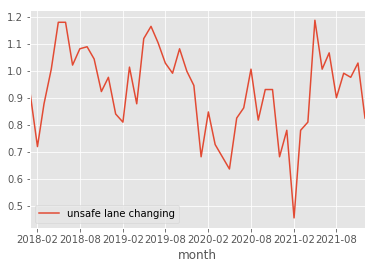

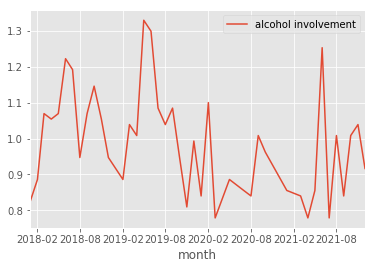

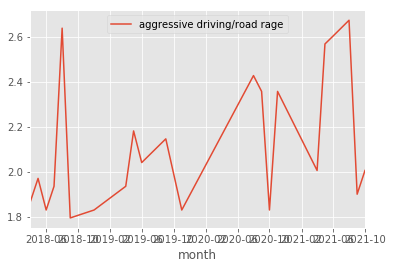

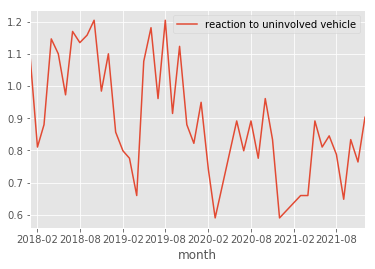

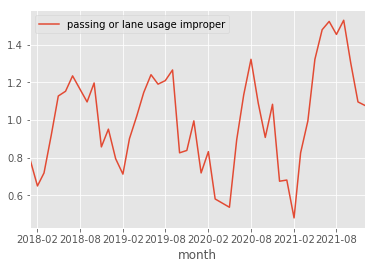

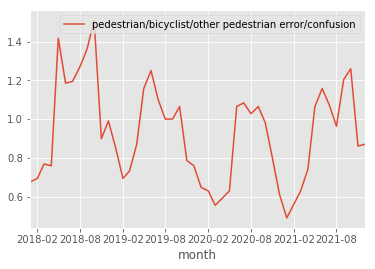

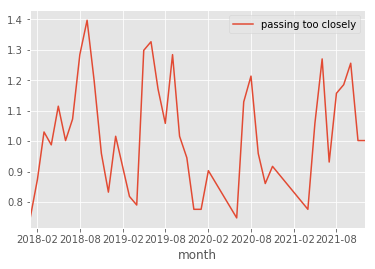

In [39]:
for cf in set(monthly_cf_df['cf']):
    try:
        monthly_cf_df[monthly_cf_df['cf'] == cf].plot(x='month', y='normalized', label=cf)
    except:
        print(cf)

Get Monthly Raw Inj Crash #s

In [40]:
all_monthly_df = db.dfquery("""

select 
    date_trunc('month', crash_date)::date as "Month", 
    count(distinct c.crashid)
from 
    wc_accident_f c 
where 
    crash_date between '2018-01-01' and '2021-12-31'
    and crashid in (select crashid from wc_accident_victim_f)
group by 1

""") 

all_monthly_df['normalized'] =  all_monthly_df['count']/(all_monthly_df[(pd.to_datetime(all_monthly_df['Month']).dt.year.isin([2018, 2019]))].sum()['count']/24.0)

Re-calculate Category Violation #s

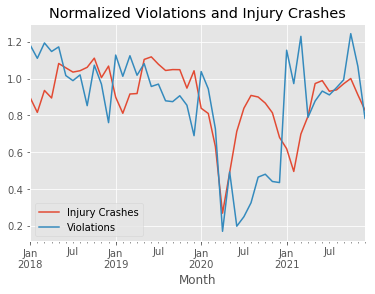

In [41]:
all_vio_monthly = db.dfquery("""
with pre_covid_avg as (

select 
    count(*)/24.0 as pre_avg
from 
    working.loaded_summons 
where 
    violation_date::date between '2018-01-01' and '2019-12-31'
    and veh_category in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
)

select distinct 
    date_trunc('month', violation_date::date)::date "Month", 
    count(*) "Violations", 
    count(*)/(1.0*pre_avg) as "Normalized"
from 
    working.loaded_summons, pre_covid_avg s 
where 
    veh_category in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
group by 1, pre_avg 

""")

all_vio_monthly['Normalized'] = all_vio_monthly['Normalized'].astype('float')
all_vio_monthly['Month'] = pd.to_datetime(all_vio_monthly['Month'])
all_monthly_df['Month'] = pd.to_datetime(all_monthly_df['Month'])

ax = all_monthly_df.plot(x='Month', y='normalized', label='Injury Crashes', title='Normalized Violations and Injury Crashes')
all_vio_monthly.plot(x='Month', y='Normalized', label='Violations', ax=ax).get_figure().savefig('NormalizedViolationsAndInjuryCrashes.png')  #title='Violations by Month (Normalized)')


In [42]:
# monthly_cf_df[monthly_cf_df['cf'] == 'turning improperly']

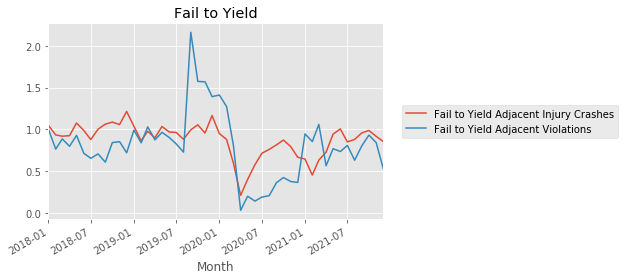

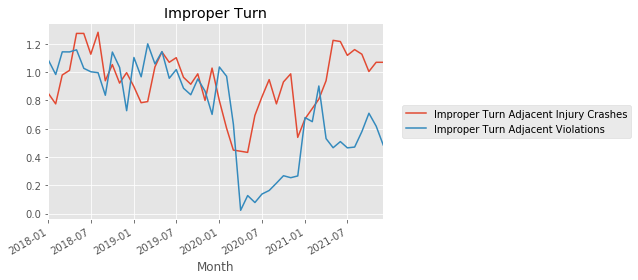

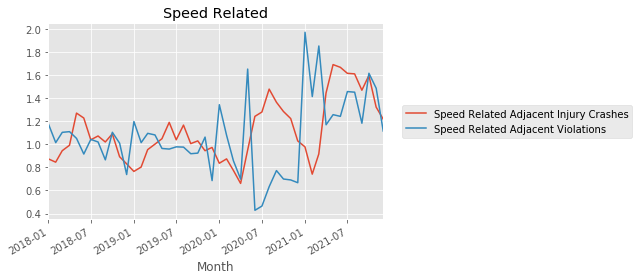

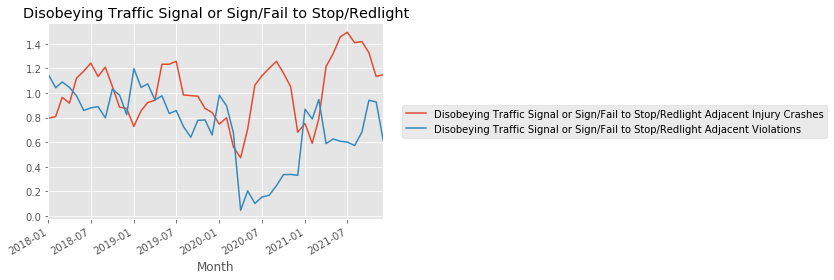

In [43]:
for cf_cat, vio_cat in [
    ('failure to yield right-of-way', 'Fail to Yield'), 
    ('turning improperly', 'Improper Turn'), 
    ('unsafe speed', 'Speed Related'),  
    ('traffic control disregarded', 'Disobeying Traffic Signal or Sign/Fail to Stop/Redlight'), 
    #('unsafe lane changing, passing or lane usage improper', 'Fail/Improper Signaling')
]:
    ax = monthly_cf_df[monthly_cf_df['cf'] == cf_cat].plot(x='month', y='normalized', label='{} Adjacent Injury Crashes'.format(vio_cat))
    ax = cat_breakdown[cat_breakdown['category'] == vio_cat].plot(ax=ax, x='Month', y='normalized', label='{} Adjacent Violations'.format(vio_cat), title=vio_cat)
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    ax.get_figure().savefig('{}ViolationsAndInjuryCrashes.png'.format(vio_cat.replace(' ', '').replace('/', '')),  bbox_inches="tight") 
    plt.show()

Police Precinct

In [44]:
# df = db.dfquery("""

# select 
#     police_precinct, 
#     date_part('month', violation_date::date) as month, 
#     count(*) 
# from
#     working.loaded_summons 
# where 
#     violation_date::date between '2019-01-01' and '2019-12-31'
#     and category='Fail to Yield'
# group by 1, 2

# """).pivot(index='police_precinct', columns='month', values='count').reset_index().reset_index(drop=True)

# for p in set(df['police_precinct']):
#     if not p or p == 'nan' or pd.isna(p):
#         continue
#     df[df['police_precinct'] == p].set_index('police_precinct').T.reset_index().plot(x='month', y=p)

## Violations Issues

In [45]:
# school = pysqldb.DbConnect(type='PG', server='dotdevrhpgsql01', database='schooldata', allow_temp_tables=True)
# pysqldb.pg_to_pg(school, db, org_schema='public', org_table='pluto', dest_schema='working')

DONE Geom not a node geom (< 1 ft) 

Remove Lion segment centroid 

Geom has a high proportion of overall precinct violations

In [46]:
# db.dfquery("""
# drop table if exists working.precinct_geoms; 
# create table working.precinct_geoms as 

# with high_vio_location as (

#     select 
#         s.geom, s.police_precinct, p.geom as pluto_geom, count(*) 
#     from 
#         working.loaded_summons s 
#     join 
#         working.pluto p 
#     on 
#         st_dwithin(s.geom, p.geom, 400)
#     where 
#         (lower(p.ownername) like '%nyc police department%' or bbl in (2042050001, 1013060033))
#         and veh_category in ('MCL', 'CAR/SUV', 'TRUCK/BUS')
#     group by 1, 2, 3
#     having count(*) > 300

# )


# select distinct 
#     s.* 
# from 
#     high_vio_location s 

# left join 
#     node n 
# on 
#     st_dwithin(s.geom, n.geom, 2)

# left join 
#     lion l 
# on 
#     st_dwithin(s.geom, st_centroid(l.geom), 2)

# where 
#     n.nodeid is null and l.segmentid is null

# """)

In [47]:
# db.dfquery("""

# select 
#     pg.police_precinct, count, geom, st_union(pluto_geom) as precinct_building_geom 
# from 
#     working.precinct_geoms pg 
# join (
#     select 
#         police_precinct, max(count) 
#     from 
#         working.precinct_geoms
#     group by 1 
# ) m 
# on 
#     pg.police_precinct=m.police_precinct 
#     and pg.count=m.max
# group by 1, 2, 3

# """)

Output

In [48]:
writer.save()